In [12]:
# Import libraries
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.manifold import trustworthiness

In [4]:
# Set larger font sizes for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

## Dimensionality Reduction analysis for unfiltered HCC SmartSeq dataset

In the following notebook, we will compare different dimensionality reduction techniques on the unfiltered HCC1806 SmartSeq dataset to evalaute to what extent the sparse and unprocessed data can be converted to a format suitable for clustering and, possibly also, for supervised classification.

In [5]:
# Load data
df = pd.read_csv("SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt",
                 delim_whitespace=True,
                 header=0,
                 quotechar='"',
                 index_col=0,
                 engine="python")

print("Original data shape (genes x samples):", df.shape)

# Transpose the data so that rows are samples and columns are genes/features
X = df.T.values
print("Transposed data shape (samples x features):", X.shape)

C:\Users\flamo\AppData\Local\Temp\ipykernel_20064\2762393155.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt",


Original data shape (genes x samples): (23396, 243)
Transposed data shape (samples x features): (243, 23396)


We extract the labels from the dataset only for visualisation purposes and for the final comments involving the silhouette score achieved by the different dimensionality reduction techniques

In [6]:
# Extract condition information from column names
sample_names = df.columns
conditions = []
for name in sample_names:
    if "Norm" in name:
        conditions.append("Norm")
    elif "Hypo" in name:
        conditions.append("Hypo")
    else:
        conditions.append("Unknown")

# Create condition color mapping
colors = ["blue" if c == "Norm" else "red" if c == "Hypo" else "gray" for c in conditions]
condition_labels = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions])

In [35]:
# Function to compute various evaluation metrics for dimensionality reduction
def evaluate_embeddings(original_data, embedding, labels):
    results = {}

    # 1. Silhouette score (higher is better)
    try:
        silhouette = silhouette_score(embedding, labels)
        results['silhouette_score'] = silhouette
    except:
        results['silhouette_score'] = np.nan
    
    results['trustworthiness'] = trustworthiness(original_data, embedding, n_neighbors = 5) 

    return results

We now study the dataset's variance using PCA and analysing how many PCs it takes to represent most of the variance of the standardised initial dataset. We arrive at the conclusion that only around 160 columns suffice to represent the variance of almost the whole dataset, 95%.

THerefore, dimensionality reduction is going to be be very useful for improving computation time of algorithms and their performance as well, with the clear drawback of losing genes' interpretability

In [9]:
# Standardize the data
standard_scaler = StandardScaler()
X_std = standard_scaler.fit_transform(X)

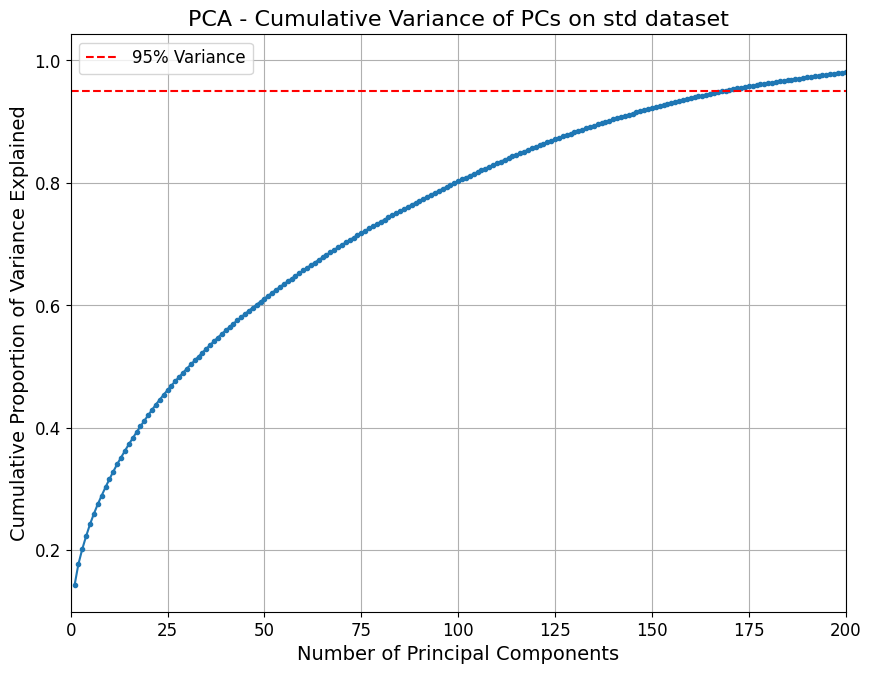

In [10]:
#after std, still 100 PCs  out of 22000 possilbe explain more than 95% variance
pca_std = PCA(random_state=42)
pca_std.fit(X_std)
cumulative_variance = np.cumsum(pca_std.explained_variance_ratio_)

# Step 4: Plot
plt.figure(figsize=(10, 7.5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker=".", linestyle='-')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance')  # Red horizontal line
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('PCA - Cumulative Variance of PCs on std dataset')
plt.xlim(0,200)
plt.grid(True)
plt.legend()
plt.show()

## Optimisation of parameters for UMAP and TSNE

In this section, we try to implmenet and select the best parameters for two dimensionality reduction methods, namely UMAP and T-SNE, by selecting parameters that preserve at best the local structure of the dataset, which is measured according to the the trustworthiness metric. 

To achieve this, we first try to select a sensible number of neighbours to be considered when computing the trustworthiness metric so that the latter mirrors what "local" structure means for the dataset based on the fllowing nearest neighbour plots.

We also provide here an intuitive notion of trustworthiness: trustworthiness, as explained in scikit' documentaion, is a metric for evaluating dimensionality reduction that lies in the interval [0,1] and indicates the extent to which the local data structure is retained. It is such that any unexpected nearest neighbors in the output space are penalised in proportion to their rank (as neighbours) in the input space.

To understand best number of neighbours for trustwrothiness and thus local structure, we create k-distance graph plots, for every point in the dataset for different values of k and compare for which plot there is the sharpest increase in distance of neighbours. These plots show for each sample:

- The distance to its k-th nearest neighbor on the y-axis,

- Against a sorted index of points on the x-axis, i.e., the points are ordered by distance.

k-distance graphs help in understanding the density of the dataset. 
A sharp increase in distance (i.e., when the graph flattens suddenly) indicates a possible change from dense clusters to sparse regions, which can help inform the optimal value for n_neighbors in trustworhtiness score or the level of "granularity" (i.e. how fine the unit grid of space is) of the dataset.

A small value for n_neighbors focuses on local structure (fine details) while a large value for n_neighbors captures more global structure, potentially leading to smoother embeddings but possibly losing fine details.

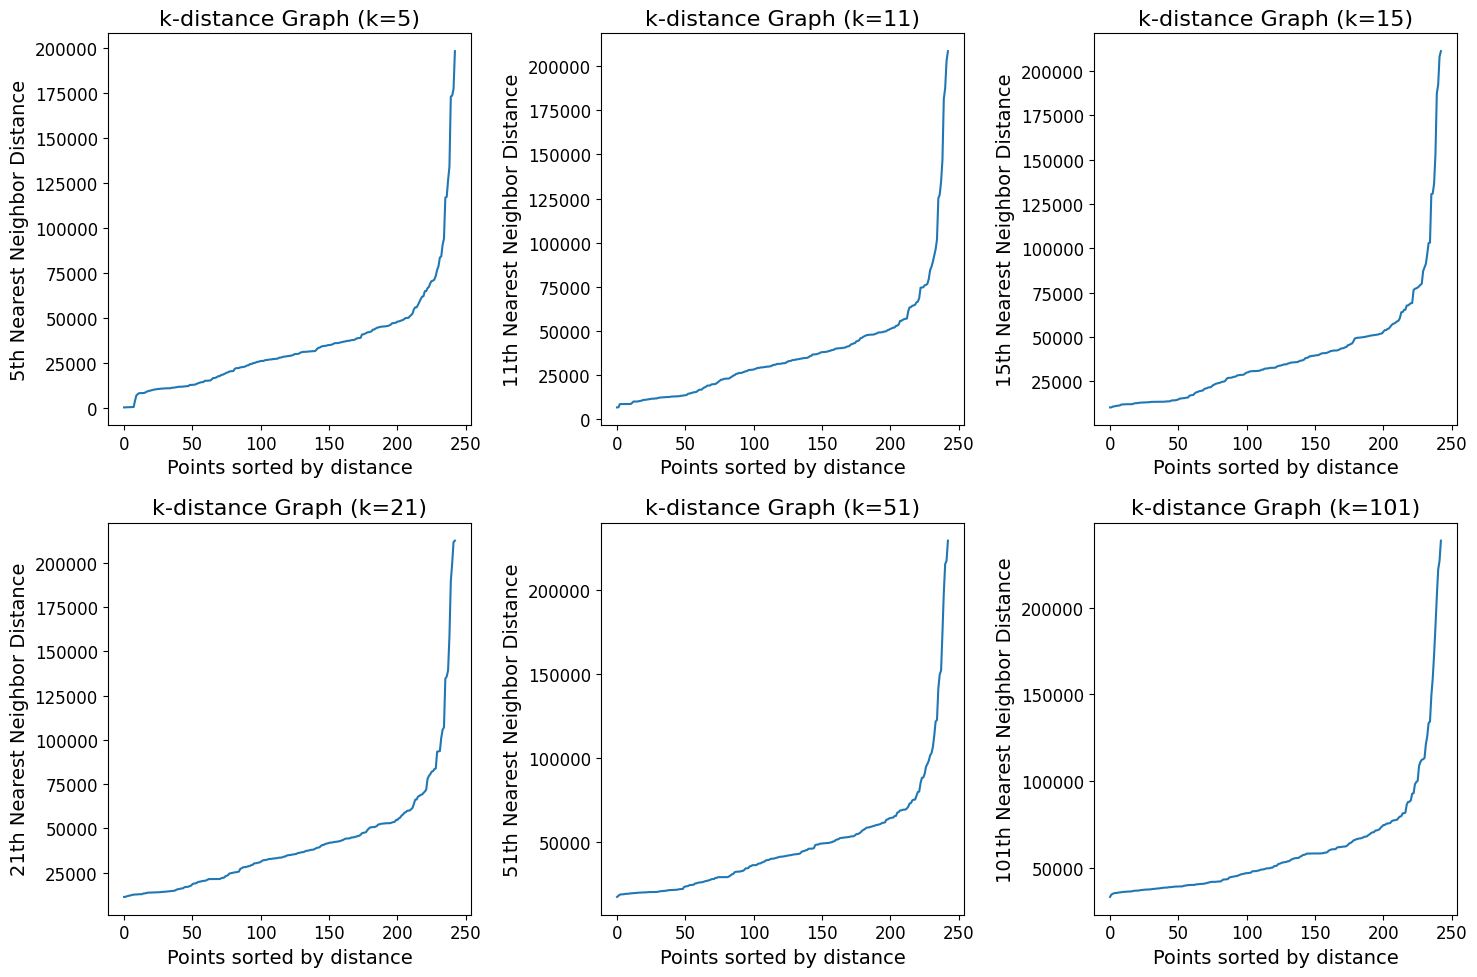

In [11]:
# k-distance analysis for UMAP parameter selection
k_values = [5, 11, 15, 21, 51, 101]

# Create subplots for each k-distance graph
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, k in enumerate(k_values):
    # Fit NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)

    # Get distances to k-th nearest neighbor
    distances, indices = neighbors_fit.kneighbors(X)
    sorted_distances = np.sort(distances[:, k - 1])  # k-1 for zero-indexed column

    # Plot the k-distance graph
    axs[i].plot(sorted_distances)
    axs[i].set_title(f'k-distance Graph (k={k})')
    axs[i].set_xlabel('Points sorted by distance')
    axs[i].set_ylabel(f'{k}th Nearest Neighbor Distance')

plt.tight_layout()
plt.savefig("hcc1806_k_distance_graphs.png", dpi=300)
plt.show()

### In our analysis, we choose to preserve more the local structure of the dataset instead of the global one, by selecting a small number of neighbours for the trustworthiness metric, namely 5 (as also indicated by best "elbow" in nearest neighbour graph), since the high-dimensional dataset is likely to be sparse and so the overall positioning of datapoints might be misleading. The latter is then used to optimise the best performing parameters of UMAP and TSNE for (a local) trustworthiness.

In [14]:
# Define trustworthiness-based scoring function
def trustworthiness_scorer(estimator, X):
    X_embedded = estimator.named_steps['umap'].fit_transform(X)
    return trustworthiness(X, X_embedded, n_neighbors=5)

# Define pipeline: UMAP followed by nothing (or you can later add KMeans if needed)
pipe = Pipeline([
    ('umap', umap.UMAP(random_state=10))
])

# Parameter distribution using pipeline parameter names
param_dist = {
    'umap__n_neighbors': np.arange(5, 40),
    'umap__min_dist': np.linspace(0.0, 1, 50),
    'umap__metric': ['correlation', 'cosine'],
}

# Run RandomizedSearchCV using trustworthiness
search_U_T = RandomizedSearchCV( pipe,  param_distributions=param_dist, n_iter=100, cv=5, verbose=1, scoring=trustworthiness_scorer, random_state=22)

# Fit to data
search_U_T.fit(X)

# Print best parameters and best score
print("Best UMAP params:")
print(search_U_T.best_params_)
print(f"Best trustworthiness score: {search_U_T.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs valu

Best UMAP params:
{'umap__n_neighbors': np.int64(18), 'umap__min_dist': np.float64(0.3061224489795918), 'umap__metric': 'correlation'}
Best trustworthiness score: 0.6739


In [15]:
# Custom function to compute t-SNE and return trustworthiness
def evaluate_tsne_trustworthiness(X, n_components, perplexity, learning_rate, max_iter):
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=10
    )
    X_embedded = tsne.fit_transform(X)
    trust = trustworthiness(X, X_embedded, n_neighbors=5)  # You can adjust n_neighbors
    return trust

# Define parameter ranges
n_components_range = [2, 3]
perplexity_range = np.arange(5, 51, 5)  # 5 to 50
learning_rate_range = np.logspace(-2, 2, 5)  # 0.01 to 100
max_iter_range = [250, 500, 1000]

# Number of random combinations to try
n_iter = 500

# Store results
results = []

# Random parameter search
for _ in range(n_iter):
    n_components = np.random.choice(n_components_range)
    perplexity = np.random.choice(perplexity_range)
    learning_rate = np.random.choice(learning_rate_range)
    max_iter_val = np.random.choice(max_iter_range)

    trust = evaluate_tsne_trustworthiness(
        X, n_components, perplexity, learning_rate, max_iter_val
    )
    results.append({
        'n_components': n_components,
        'perplexity': perplexity,
        'learning_rate': learning_rate,
        'max_iter': max_iter_val,
        'trustworthiness': trust
    })
    print(f"Iteration completed - Trustworthiness: {trust:.4f}")

# Find best parameters
best_result = max(results, key=lambda x: x['trustworthiness'])
print("\nBest parameters (by trustworthiness):")
print(f"t-SNE n_components: {best_result['n_components']}")
print(f"t-SNE perplexity: {best_result['perplexity']}")
print(f"t-SNE learning_rate: {best_result['learning_rate']}")
print(f"t-SNE max_iter: {best_result['max_iter']}")
print(f"Trustworthiness: {best_result['trustworthiness']:.4f}")

c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, 

Iteration completed - Trustworthiness: 0.7987
Iteration completed - Trustworthiness: 0.8602
Iteration completed - Trustworthiness: 0.7983
Iteration completed - Trustworthiness: 0.9470
Iteration completed - Trustworthiness: 0.7149
Iteration completed - Trustworthiness: 0.9391
Iteration completed - Trustworthiness: 0.9450
Iteration completed - Trustworthiness: 0.7983
Iteration completed - Trustworthiness: 0.8023
Iteration completed - Trustworthiness: 0.7952
Iteration completed - Trustworthiness: 0.9501
Iteration completed - Trustworthiness: 0.9436
Iteration completed - Trustworthiness: 0.8543
Iteration completed - Trustworthiness: 0.9341
Iteration completed - Trustworthiness: 0.7957
Iteration completed - Trustworthiness: 0.8068
Iteration completed - Trustworthiness: 0.9444
Iteration completed - Trustworthiness: 0.8115
Iteration completed - Trustworthiness: 0.6811
Iteration completed - Trustworthiness: 0.9350
Iteration completed - Trustworthiness: 0.7997
Iteration completed - Trustworthin

## Plotting results of dimensionality Reduction for UMAP and TSNE with optimised parameters and also of PCA colouring points based on true labels

In [ ]:
# Compute 2D and 3D embeddings using the best parameters
# For UMAP 2D
print("Computing UMAP 2D...")
umap_2d = umap.UMAP(
    n_neighbors=18,
    min_dist=0.306,
    n_components=2,
    metric = "correlation",
    random_state=23
)
umap_embedding_2d = umap_2d.fit_transform(X)

Computing UMAP 2D...


c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# For UMAP 3D
print("Computing UMAP 3D...")
umap_3d = umap.UMAP(
    n_neighbors=18,
    min_dist=0.306,
    n_components=3,
    metric = "correlation",
    random_state=23
)
umap_embedding_3d = umap_3d.fit_transform(X)

Computing UMAP 3D...


c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
# For t-SNE 2D
print("Computing t-SNE 2D...")
tsne_2d = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=10,
    n_iter=1000,
    random_state=23
)
tsne_embedding_2d = tsne_2d.fit_transform(X)


Computing t-SNE 2D...


c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [19]:
# For t-SNE 3D
print("Computing t-SNE 3D...")
tsne_3d = TSNE(
    n_components=3,
    perplexity=40,
    learning_rate=10,
    n_iter=1000,
    random_state=23
)
tsne_embedding_3d = tsne_3d.fit_transform(X)

Computing t-SNE 3D...


c:\Users\flamo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [20]:
# For PCA
print("Computing PCA 2D...")
pca_2d = PCA(n_components=2, random_state=42)
pca_embedding_2d = pca_2d.fit_transform(X_std)

Computing PCA 2D...


In [21]:
print("Computing PCA 3D...")
pca_3d = PCA(n_components=3, random_state=42)
pca_embedding_3d = pca_3d.fit_transform(X_std)

Computing PCA 3D...


In [22]:
# Create legend elements for all plots
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=12, label='Norm'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='Hypo')
]

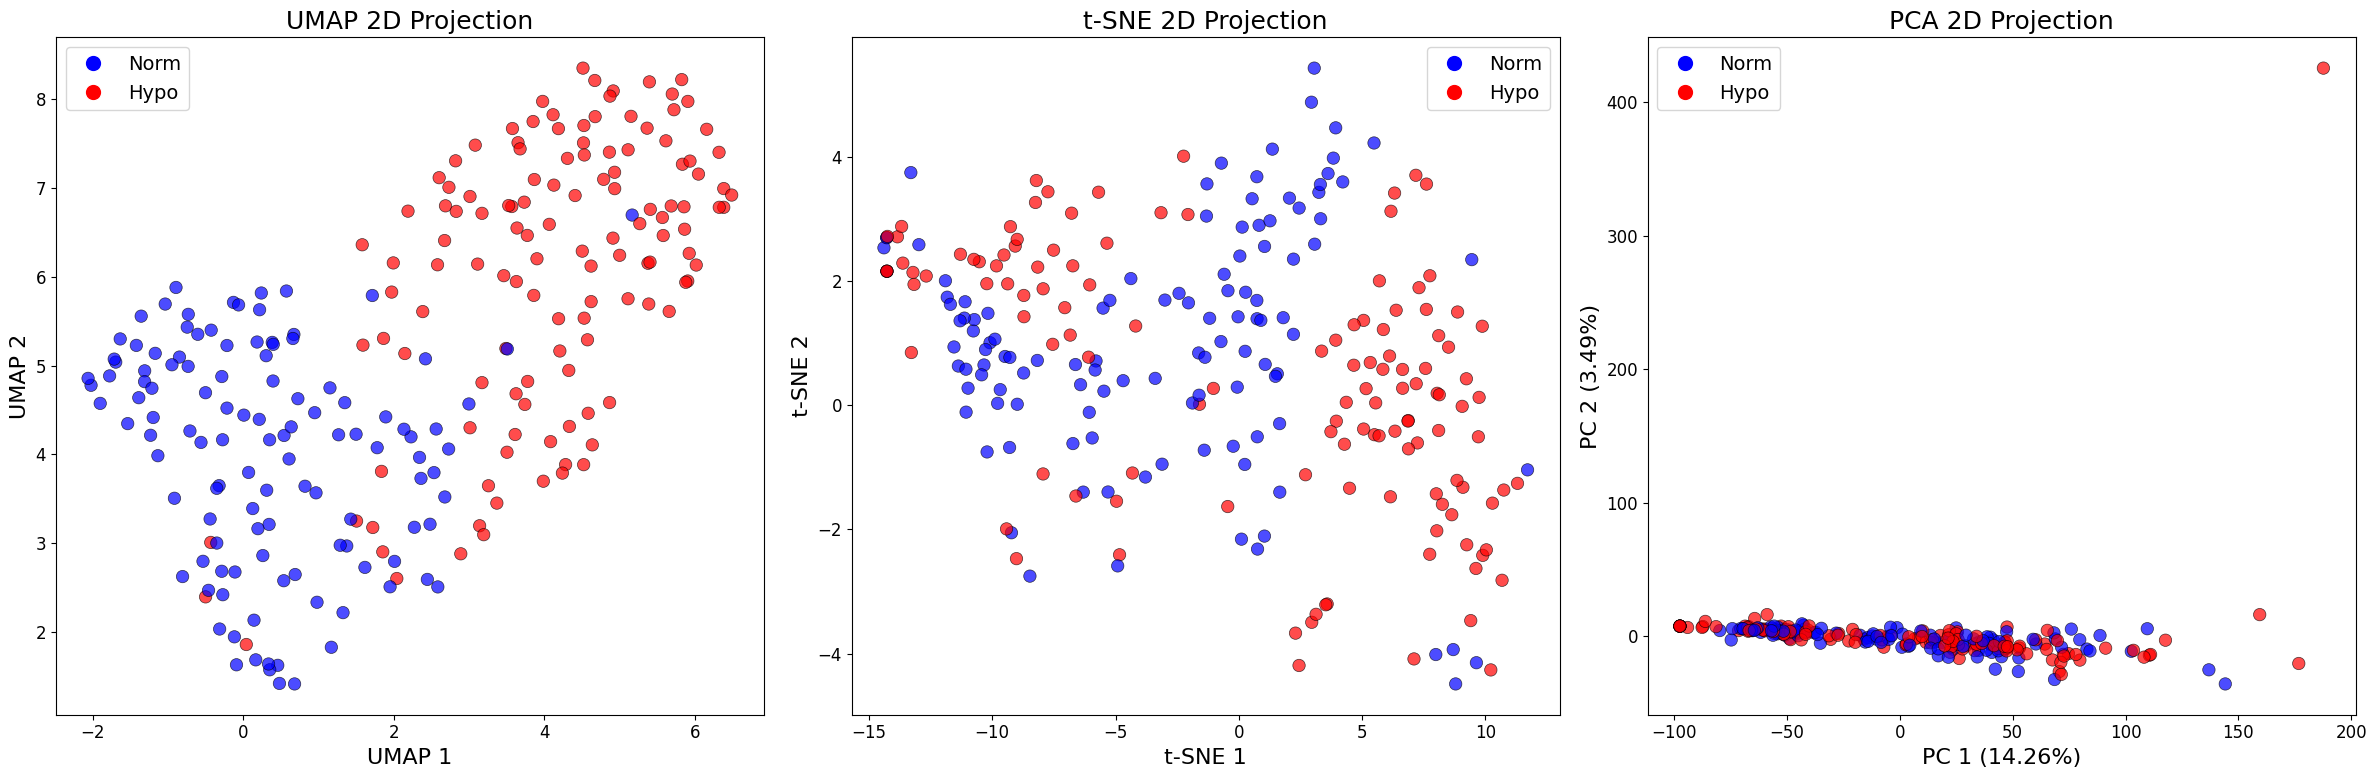

In [23]:
# Visualize 2D projections side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# UMAP 2D
axes[0].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[0].set_xlabel("UMAP 1", fontsize=16)
axes[0].set_ylabel("UMAP 2", fontsize=16)
axes[0].set_title("UMAP 2D Projection", fontsize=18)
axes[0].legend(handles=legend_elements, loc='best', fontsize=14)

# t-SNE 2D
axes[1].scatter(tsne_embedding_2d[:, 0], tsne_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[1].set_xlabel("t-SNE 1", fontsize=16)
axes[1].set_ylabel("t-SNE 2", fontsize=16)
axes[1].set_title("t-SNE 2D Projection", fontsize=18)
axes[1].legend(handles=legend_elements, loc='best', fontsize=14)

# PCA 2D
axes[2].scatter(pca_embedding_2d[:, 0], pca_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[2].set_xlabel(f"PC 1 ({pca_2d.explained_variance_ratio_[0]:.2%})", fontsize=16)
axes[2].set_ylabel(f"PC 2 ({pca_2d.explained_variance_ratio_[1]:.2%})", fontsize=16)
axes[2].set_title("PCA 2D Projection", fontsize=18)
axes[2].legend(handles=legend_elements, loc='best', fontsize=14)

plt.tight_layout()
plt.savefig("hcc1806_comparison_2d_projections.png", dpi=300)
plt.show()

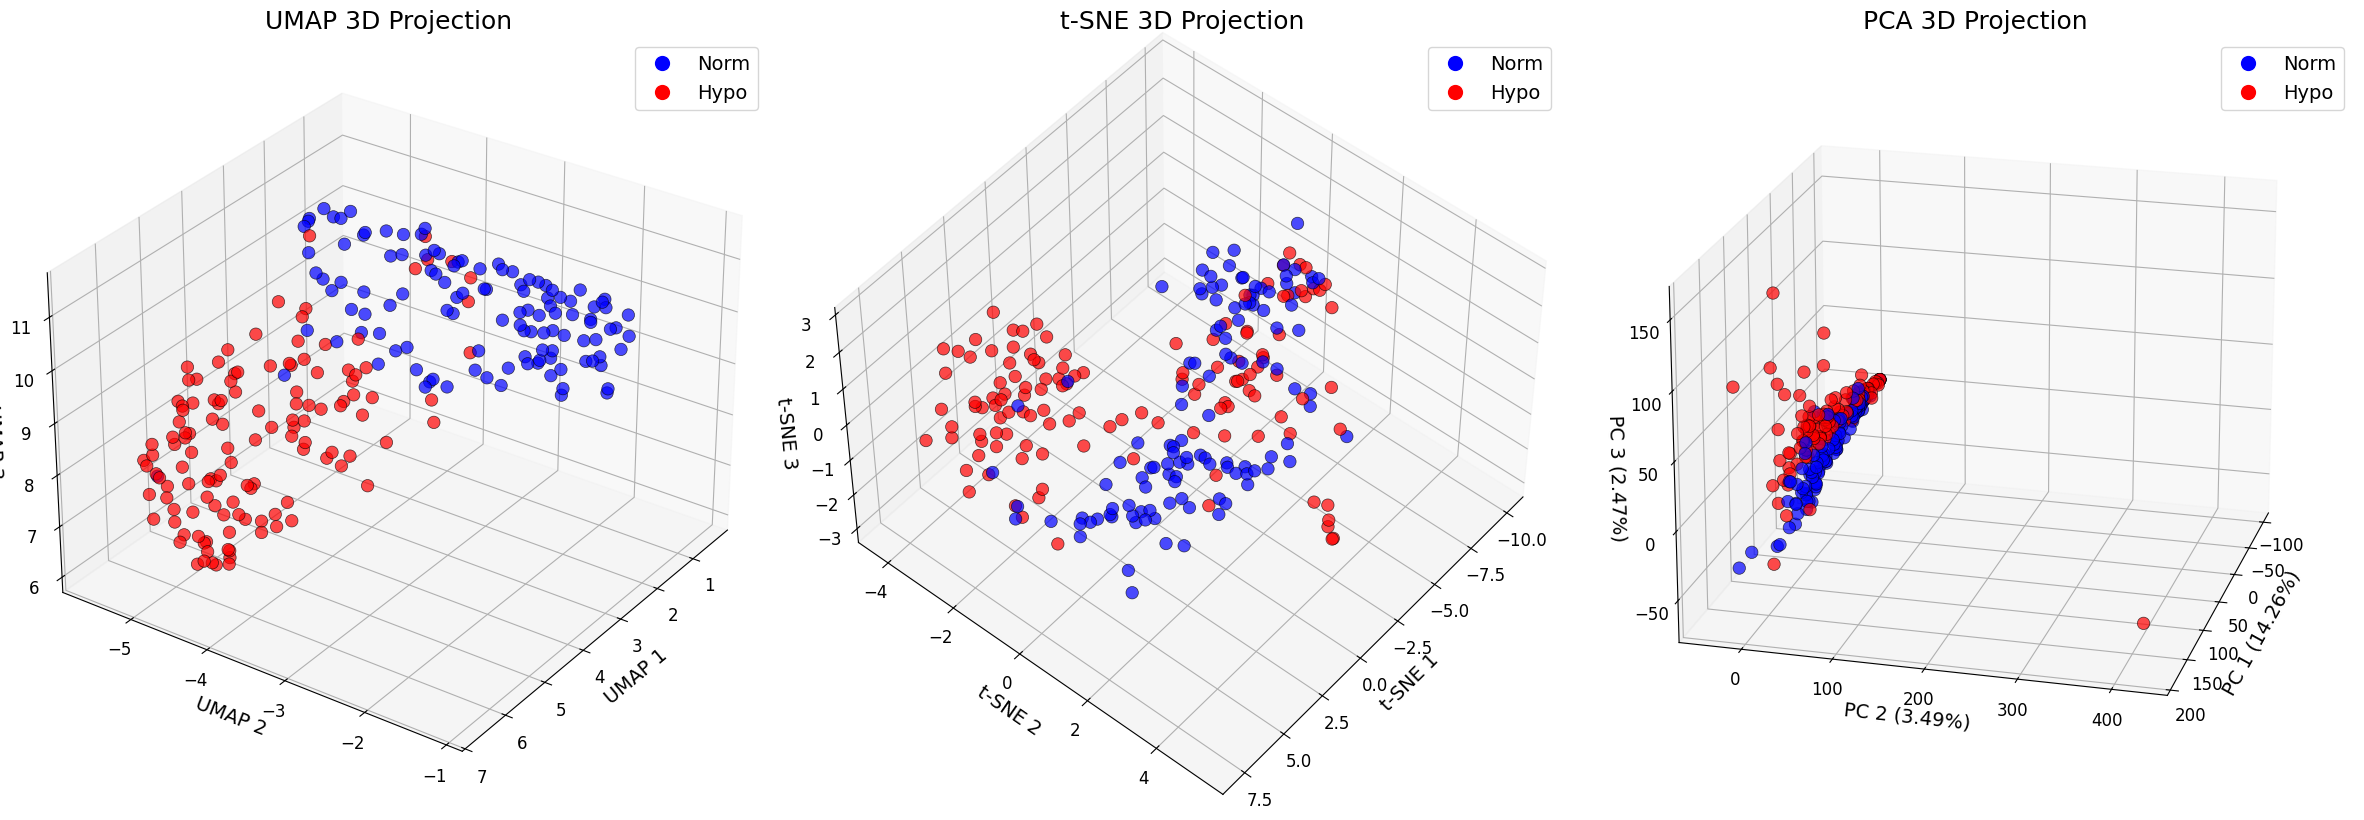

In [33]:
# Visualize 3D projections
fig = plt.figure(figsize=(24, 8))

# UMAP 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(
    umap_embedding_3d[:, 0],
    umap_embedding_3d[:, 1],
    umap_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax1.set_xlabel("UMAP 1", fontsize=14)
ax1.set_ylabel("UMAP 2", fontsize=14)
ax1.set_zlabel("UMAP 3", fontsize=14)
ax1.set_title("UMAP 3D Projection", fontsize=18)
ax1.view_init(elev=30, azim=35)
ax1.legend(handles=legend_elements, loc='upper right', fontsize=14)

# t-SNE 3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(
    tsne_embedding_3d[:, 0],
    tsne_embedding_3d[:, 1],
    tsne_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax2.set_xlabel("t-SNE 1", fontsize=14)
ax2.set_ylabel("t-SNE 2", fontsize=14)
ax2.set_zlabel("t-SNE 3", fontsize=14)
ax2.set_title("t-SNE 3D Projection", fontsize=18)
ax2.view_init(elev=50, azim=40)
ax2.legend(handles=legend_elements, loc='upper right', fontsize=14)

# PCA 3D
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(
    pca_embedding_3d[:, 0],
    pca_embedding_3d[:, 1],
    pca_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax3.set_xlabel(f"PC 1 ({pca_3d.explained_variance_ratio_[0]:.2%})", fontsize=14)
ax3.set_ylabel(f"PC 2 ({pca_3d.explained_variance_ratio_[1]:.2%})", fontsize=14)
ax3.set_zlabel(f"PC 3 ({pca_3d.explained_variance_ratio_[2]:.2%})", fontsize=14)
ax3.set_title("PCA 3D Projection", fontsize=18)
ax3.view_init(elev=20, azim=15)
ax3.legend(handles=legend_elements, loc='upper right', fontsize=14)

plt.tight_layout()
plt.savefig("hcc1806_comparison_3d_projections.png", dpi=300)
plt.show()

The results obtained from PCA and TSNE don't show qualitatively any clear separation between clusters with all data points, relativly close to one another or even randomly positioned. UMAP seems instead to produce qualitatively better clusters whose separation is much stronger compared to the other two methods. Therefore, UMAP will be used predominantly in the unsupervised analysis from now on.

## EVALUATION of PCA, UMAP and TSNE

In this section, made in view of the SUPERVISED analysis of the dataset, we analyse which of the above dimensionality reduction technique works best in terms of trustworthiness of the created embedding and of a clusters' separation score, known as silhouette score, relative to the true cluster labels.

On a basic level, the silhouette score is based on the silhouette coefficient, which is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample and then averaging the results over all samples. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters while negative values generally indicate that a sample has been assigned to the wrong cluster.

In [34]:
# Evaluate each method
print("Evaluating methods...")
# Filter out any Unknown conditions
valid_indices = [i for i, c in enumerate(conditions) if c != "Unknown"]
valid_labels = condition_labels[valid_indices]
valid_X = X[valid_indices]
valid_X_std = X_std[valid_indices]

Evaluating methods...


In [36]:
# Evaluate 2D embeddings
umap_2d_metrics = evaluate_embeddings(valid_X, umap_embedding_2d[valid_indices], valid_labels)
tsne_2d_metrics = evaluate_embeddings(valid_X, tsne_embedding_2d[valid_indices], valid_labels)
pca_2d_metrics = evaluate_embeddings(valid_X_std, pca_embedding_2d[valid_indices], valid_labels)

In [37]:
# Evaluate 3D embeddings
umap_3d_metrics = evaluate_embeddings(valid_X, umap_embedding_3d[valid_indices], valid_labels)
tsne_3d_metrics = evaluate_embeddings(valid_X, tsne_embedding_3d[valid_indices], valid_labels)
pca_3d_metrics = evaluate_embeddings(valid_X_std, pca_embedding_3d[valid_indices], valid_labels)

In [38]:
# Combine results
all_metrics = {
    "UMAP 2D": umap_2d_metrics,
    "t-SNE 2D": tsne_2d_metrics,
    "PCA 2D": pca_2d_metrics,
    "UMAP 3D": umap_3d_metrics,
    "t-SNE 3D": tsne_3d_metrics,
    "PCA 3D": pca_3d_metrics
}

# Convert to DataFrame for easier comparison
metrics_df = pd.DataFrame(all_metrics).T
print("\nComparison of Dimensionality Reduction Methods:")
print(metrics_df)


Comparison of Dimensionality Reduction Methods:
          silhouette_score  trustworthiness
UMAP 2D           0.450895         0.639212
t-SNE 2D          0.100830         0.942488
PCA 2D           -0.003038         0.543966
UMAP 3D           0.407514         0.670677
t-SNE 3D          0.069302         0.962760
PCA 3D            0.041803         0.564732


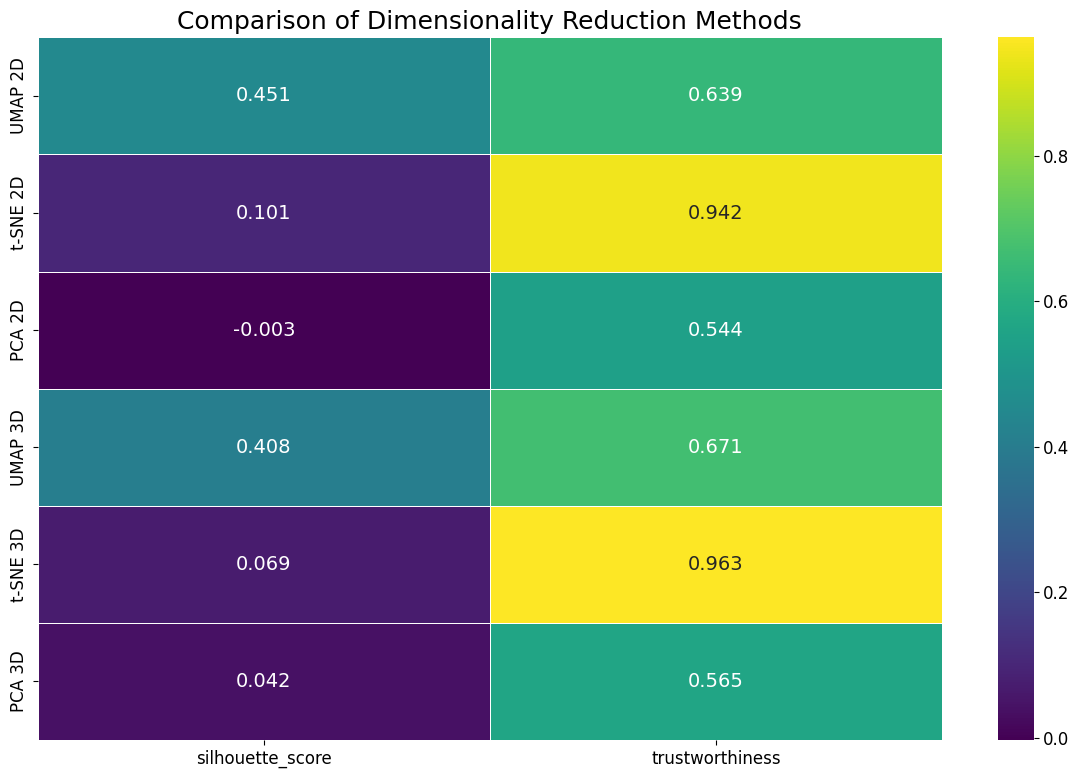

In [39]:
# Create a heatmap to visualize the comparison
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df, annot=True, cmap="viridis", linewidths=.5, fmt=".3f")
plt.title("Comparison of Dimensionality Reduction Methods", fontsize=18)
plt.tight_layout()
plt.savefig("hcc1806_method_comparison_heatmap.png", dpi=300)
plt.show()

As can be seen from above, PCA is the worst performing method for both trustwrothiness and silhouette score showing that that it is most likely too simple for the complexity of the given high-dimensional dataset.

Differently, TSNE is the method maximisng the trsuwrothiness of the representation of the local structure of the dataset, despite having very low silhouette scores as could be expected from the plots created above.

Finally, UMAP achieves the best compromise for both metrics since it possesses a reasonably high trustworthiness score, thus maintaning local structure, while achieving the highest silhouette scores, thus separating well the cluster of true labels.

In the next cells, we combine silhoutte score and trustworthiness score into a single normlized metric taking valus between 0 and 1 in order to better visualise the results.

In [40]:
# Calculate an overall score (weighted average of normalized metrics)
# Normalize metrics to 0-1
normalized_metrics = metrics_df.copy()

# For metrics where higher is better
for metric in ['silhouette_score']:
    min_val = normalized_metrics[metric].min()
    max_val = normalized_metrics[metric].max()
    if max_val > min_val:
        normalized_metrics[metric] = (normalized_metrics[metric] + 1) / 2

In [41]:
# Define weights for each metric
weights = {
    'silhouette_score': 0.5,  # Measures cluster separation
    'trustworthiness': 0.5,  # Measures preservation of local structure
}

# Calculate weighted score
normalized_metrics['weighted_score'] = sum(normalized_metrics[metric] * weight
                                         for metric, weight in weights.items())

# Sort by weighted score
normalized_metrics = normalized_metrics.sort_values('weighted_score', ascending=False)

print("\nRanking of Methods (higher is better):")
print(normalized_metrics[['weighted_score']])


Ranking of Methods (higher is better):
          weighted_score
t-SNE 3D        0.748705
t-SNE 2D        0.746452
UMAP 3D         0.687217
UMAP 2D         0.682330
PCA 3D          0.542817
PCA 2D          0.521224


<Figure size 1200x800 with 0 Axes>

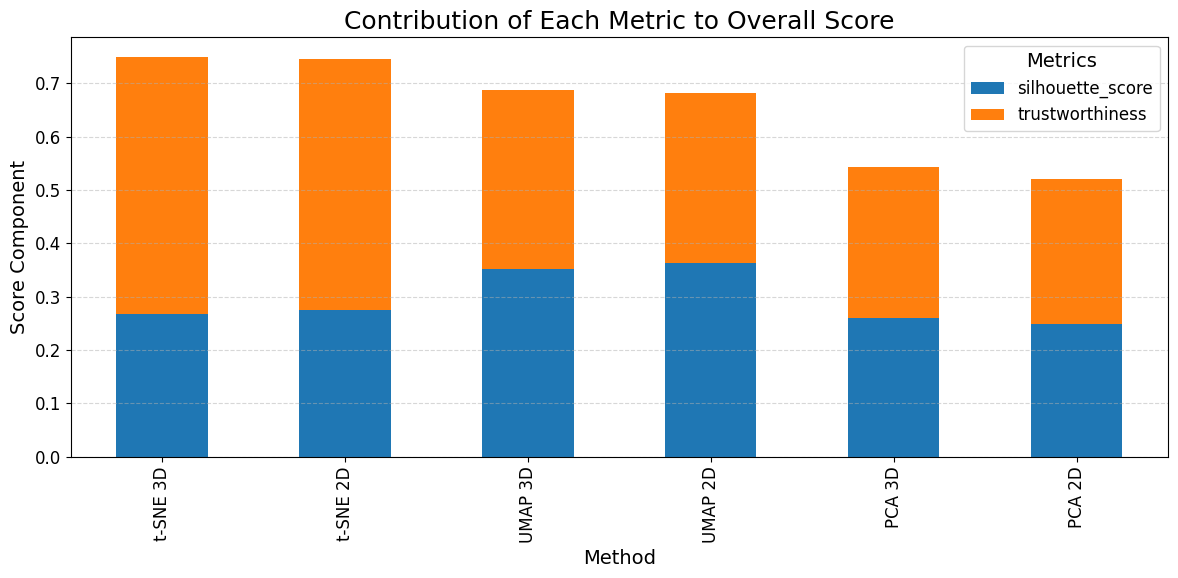

In [42]:
# Additional visualization: Contribution of each metric to overall score
contribution_df = pd.DataFrame({
    metric: normalized_metrics[metric] * weight
    for metric, weight in weights.items()
}, index=normalized_metrics.index)

plt.figure(figsize=(12, 8))
contribution_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Contribution of Each Metric to Overall Score', fontsize=18)
plt.xlabel('Method')
plt.ylabel('Score Component')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("hcc1806_score_components.png", dpi=300)
plt.show()

Even if TSNE achieves the best overall value of the combined metric, it still performs considreably worse comapred to UMAP for what concerns the silhouette score, thus rendering it less suitable for further analysis